In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np

from irc.manager import IRCManager
from boxforage.utils import plot_single_box_episode

# Train one agent for a single box environment

In [2]:
manager = IRCManager(defaults='irc_defaults/single_box.yaml')

## Train an agent
We train a rational agent for the assume environment parameter $p_\mathrm{appear}=0.2, p_\mathrm{cue}=0.8, r_\mathrm{food}=10$.

The following can also be done by running `demo-train.py` in command line:
```bash
python demo-train.py env_param=[0.2,0.8,10] num_epochs=10
```

Checkpoint (epoch 10) loaded.
Fetching the most trained agent so far (epoch 10).
Agent (seed 1) was trained for 10 epochs.


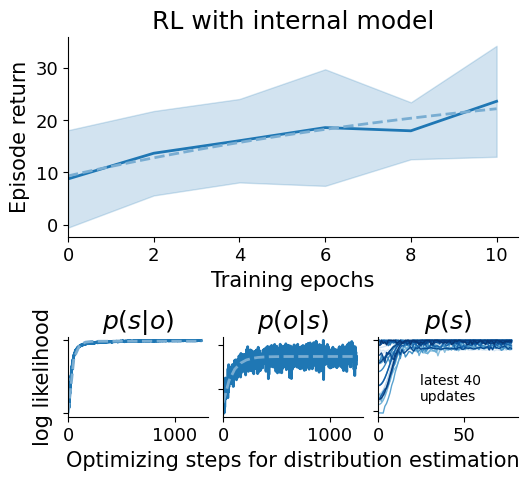

In [3]:
env_param = [0.2, 0.8, 10]
num_epochs = 10

agent = manager.train_agent(env_param, num_epochs=num_epochs)
agent, fig = manager.inspect_agent(env_param)

## Run the agent in an environment
We create another environment which has the same observation space and action space as the assumed one, albeit with a different set of environment parameters $(0.3, 0.6, 10)$.

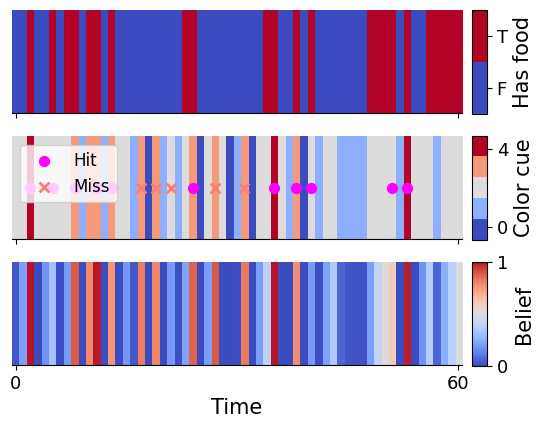

In [4]:
from boxforage.single_box import SingleBoxForaging

env = SingleBoxForaging(spec=manager.agent_manager.defaults.env.spec)
env.set_param([0.3, 0.6, 10.])

episode = agent.run_one_episode(env=env, num_steps=60)
fig = plot_single_box_episode(episode)

We can save the episode data in an external `pickle` file.

In [5]:
import os, pickle

episode_path = 'store/episode_00.pickle'

if os.path.exists(episode_path):
    print(f"File {episode_path} already exists, will not be overwritten.")
else:
    with open(episode_path, 'wb') as f:
        pickle.dump({
            'external_env_param': env.get_param(),
            'internal_env_param': agent.model.env.get_param(),
            **episode,
        }, f)
    print(f"Episode data saved at '{episode_path}'.")

File store/episode_00.pickle already exists, will not be overwritten.


# Train multiple agents for different environments

## Sweep over parameter grid

We define a grid of environment parameters, and train multiple agents for each of the combination using different random seeds.

The following can also be done by running `demo-sweep.py` in command line:
```bash
python demo-sweep.py env_param_grid=param_grids/single_box.yaml num_epochs=10 count=5
```

In [6]:
env_param_grid = [
    [0.05, 0.15, 0.2, 0.25], # p_appear
    [0.2, 0.4, 0.6, 0.8], # p_cue
    [2., 10.], # r_food
]

num_epochs = 10 # number of RL epochs
count = 5 # number of agents to be trained
manager.train_agents(env_param_grid=env_param_grid, num_epochs=num_epochs, count=count)

Use default agent seeds [0, 1, 2] for each environment parameter.
------------
Processing 4314F7AA (1/5)...
No checkpoint loaded.

0 works processed.


In [7]:
report = manager.agents_overview(env_param_grid=env_param_grid)

Use default agent seeds [0, 1, 2] for each environment parameter.
Average number of trained epochs: 2.9
Approximate training time 7m17.18s per epoch.
Approximate evaluation time 0m52.08s.
Average training optimality 94.7%


# Compute likelihood of an episode

## Likelihood of a specific agent

Given a sequence actions and observations, we compute the likelihood of episode data conditioned on a trained agent $p(a_{1:t}, o_{1:t}|\theta_\mathrm{agent})$.

In [8]:
logp = agent.episode_likelihood(episode['actions'], episode['observations'])
print('log likelihood {:.3f}'.format(logp))

log likelihood -13.861


## Likelihood of a series of agents

After multiple agents have been trained on a grid of environment parameters, compute the likelihood of episode data conditioned on each agent.

In [12]:
from irc.utils import logmeanexp

episode_path = 'store/episode_00.pickle'
env_param_grid = [
    [0.05, 0.15, 0.2, 0.25], # p_appear
    [0.2, 0.4, 0.6, 0.8], # p_cue
    [2., 10.], # r_food
]

logps = manager.compute_logps(episode_path=episode_path, env_param_grid=env_param_grid, min_epoch=5)
logps = logmeanexp(logps, axis=(-2, -1))
print(f"Log likelihood of all environments saved in an array of shape {logps.shape}")

Use default seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run of belief updates.
Use default agent seeds [0, 1, 2] for each environment parameter.
19 valid agents found.
------------
Processing 03AE63D5 (1)...
No checkpoint loaded.
Log likelihood of an agent (trained for  5 epochs): -21.225 (0m13.19s)
------------
------------
Processing D01199AF (2)...
No checkpoint loaded.
Log likelihood of an agent (trained for  5 epochs): -52.882 (0m13.30s)
------------
------------
Processing 8E721639 (3)...
No checkpoint loaded.
Log likelihood of an agent (trained for  5 epochs): -43.383 (0m13.29s)
------------
------------
Processing 2CE4BD5B (4)...
No checkpoint loaded.
Log likelihood of an agent (trained for  5 epochs): -43.686 (0m13.32s)
------------
------------
Processing CA16A48E (5)...
No checkpoint loaded.
Log likelihood of an agent (trained for  5 epochs): -52.927 (0m13.51s)
------------
------------
Processing 72341D9A (6)...
No checkpoint loaded.
Log likelihood of an agent (trained for  5 e